In [1]:
from qiskit import *
from qiskit import QuantumRegister
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, IBMQ
import matplotlib as mpl
import random
import pylatexenc


# Logic Gates

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q")

In [32]:
##
##  A class to wrap the qiskit QuantumCircuit
##    It can allocate registers in sequence, which is very useful
##
class QC:
    def __init__(self, genBarriers=True):
        self.regNum = 0
        self.genBarriers = genBarriers
        self.qc = QuantumCircuit()
        self.falseBit = self.addReg('false')
        self.trueBit  = self.addReg('true')
        self.qc.x(self.trueBit)
        
    
    def addReg(self, prefix="t"):
        name = self.get_name(prefix)
        result = QuantumRegister(1, name)
        self.qc.add_register(result)
        return result
    
    def mbit(self, qbit):
        result = ClassicalRegister(1, "m"+qbit.name)
        self.qc.add_register(result)
        self.qc.measure(qbit, result)
        return result

    def barrier(self):
        if self.genBarriers:
            self.qc.barrier()

    def em(self, shots=512):
        em = Aer.get_backend("qasm_simulator")
        job = execute(self.qc, em, shots=shots)
        hist = job.result().get_counts()
        return hist
    
    def sv(self):
        svs = BasicAer.get_backend("statevector_simulator")
        job = execute(self.qc, svs)
        ket = job.result().get_statevector()
        return ket
    
    def get_name(self, prefix=""):
        name = prefix+"_"+str(self.regNum)
        self.regNum+=1
        return name
    
    def genOutput(self, reg, name):
        reg = reg if reg else self.addReg(name)
        return reg
    
    def qand(self, bit1, bit2, output=None):
        output = self.genOutput(output, "and")
        self.barrier()
        self.qc.ccx(bit1, bit2, output)
        self.barrier()
        return output


    def qor(self, bit1, bit2, output=None):
        output = self.genOutput(output, "or")
        self.barrier()
        self.qc.cx(bit1, output)
        self.qc.cx(bit2, output)
        self.qc.ccx(bit1, bit2, output)
        self.barrier()
        return output
    
    def qxor(self, bit1, bit2, output=None):
        output = self.genOutput(output, "xor")
        self.barrier()
        self.qc.cx(bit1, output)
        self.qc.cx(bit2, output)
        self.barrier()
        return output
##
##  While we don't need this method for completeness,
##     it can perform a 3-way xor without generating a
##     temporary, intermediate result, thus saving qubits
##
    def qxor3(self, bit1, bit2, bit3, output=None):
        output = self.genOutput(output, "xor3")
        self.barrier()
        self.qc.cx(bit1, output)
        self.qc.cx(bit2, output)
        self.qc.cx(bit3, output)
        self.barrier()
        return output

    def qnot(self, bit, output=None):
        output = self.genOutput(output, "not")
        self.barrier()
        self.qc.x(bit)
        self.qc.cx(bit, output)
        self.qc.x(bit)
        self.barrier()
        return output

    def qnand(self, bit1, bit2, output=None):
        output = self.genOutput(output, "nand")
        self.barrier()
        self.qc.ccx(bit1, bit2, output)
        self.qc.x(output)
        self.barrier()
        return output

###
### A more qulever carry computation, requiring no intermediate results
###   If exactly two bits are true, the output is flipped once, making it True
##    If all three are true, the output flips 3 times, making it True
##    If exactly one bit is true, no flipping occurs
##
    def quarry(self, bit1, bit2, bit3, output=None):
        output = self.genOutput(output, "quarry")
        self.qc.barrier()
        self.qc.ccx(bit1, bit2, output)
        self.qc.ccx(bit2, bit3, output)
        self.qc.ccx(bit1, bit3, output)
        self.qc.barrier()
        return output
    
    
    def draw(self, output='mpl'):
        return self.qc.draw(output=output)

In [38]:
##
##  Create integers and sums for the supplied quantum circuit
##    Throughout, a value is represented as a list of quantum registers,
##      least-significant-bit-first
##
class QArith:
    def __init__(self, qc, width):
        self.qc = qc
        self.width = width
        self.ONE   = self.qint(1, "one")

##
##  Create the supplied value on the quantum circuit
##
    def qint(self, val, name=None):
        if not name:
            name = "qi("+str(val)+")"
        bitVal = []
        a = 1
        for i in range(self.width):
            t = self.qc.addReg(name)
            if val & a:
                qc.qc.x(t)
            a = a << 1
            bitVal.append(t)
        return bitVal

##
##  cin -- carry in
##  ba - one bit of input
##  bb -- other bit of input
##  returns the sum and carry bits
##  Note:  this is correct but chews up many temporary qubits
##
    def onebit(self, cin, ba, bb):
        ##
        ##  Using a 3-way :-) to save on qubits
        ##
        s = self.qc.qxor3(cin, ba, bb)
        ##
        ##  https://en.wikipedia.org/wiki/Adder_(electronics)#Full_adder
        ##  ba bb   +   cin (ba xor bb)
        ##  cout = self.qc.qor(self.qc.qand(ba,bb), self.qc.qand(cin,self.qc.qxor(ba,bb)))
        ##  Not using the above formuala, correct though it be
        ##    It generates 3 intermediate results, but the line below generates none
        ##
        cout = self.qc.quarry(cin, ba, bb)
        return s, cout
##
##  add the two inputs, returning the result
##
##  NB:  There is an opportunity to save one qubit here
##     The onebit call always generates both the sum s and the carry out, 
##        received as carry.  The carry is needed in the middle but not for
##        the very last onebit call
##     Making onebit aware of this would make the code ugly, I think [ RKC ]
##     Perhaps better would be to compute the sum and carry separately
##        and avoid the carry the last time. The onebit method is really just
##        those two calls, anyway, so this wouldn't be so hard.
##
    def add(self, val1, val2):
        ans   = []
        carry = self.qc.falseBit
        for i in range(self.width):
            s, carry = self.onebit(carry, val1[i], val2[i])
            ans.append(s)
        return ans
    
    def onescomp(self, val):
        self.qc.barrier()
        ans = []
        for i in range(self.width):
            reg = self.qc.addReg("oc_"+val[i].name)
            self.qc.qc.x(val[i])
            self.qc.qc.cx(val[i], reg)
            self.qc.qc.x(val[i])
            ans.append(reg)
        self.qc.barrier()
        return ans
            
    def neg(self, val):
        return self.add(self.onescomp(val), self.ONE)
    
    def measure(self, val):
        result = []
        for i in range(self.width):
            b = self.qc.mbit(val[i])
            result.append(b)
        return result
    
    

[QuantumRegister(1, 'xor3_22'), QuantumRegister(1, 'xor3_24'), QuantumRegister(1, 'xor3_26'), QuantumRegister(1, 'xor3_28')]
[ClassicalRegister(1, 'mxor3_22'), ClassicalRegister(1, 'mxor3_24'), ClassicalRegister(1, 'mxor3_26'), ClassicalRegister(1, 'mxor3_28')]


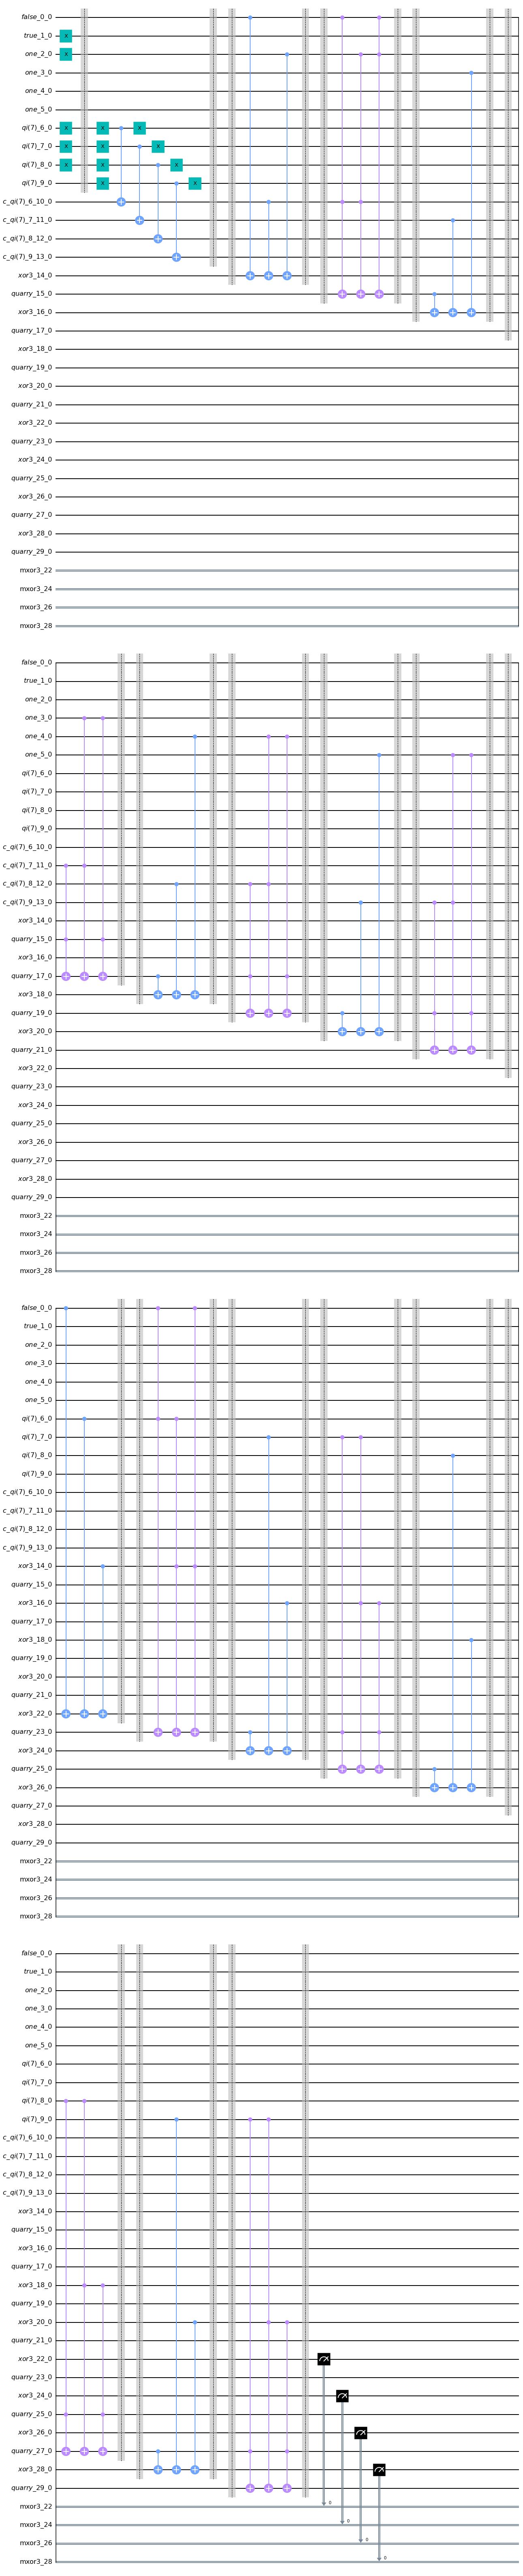

In [43]:
qc = QC()
qi = QArith(qc, 4)
a = qi.qint(7)
b = qi.neg(a)
ans = qi.add(a,b)
print(ans)
print(qi.measure(ans))
qc.draw()


In [44]:
qc.em(shots=8)




{'0 0 0 0': 8}

In [27]:
q4 = QuantumRegister(3,'q')
c4 = ClassicalRegister(2,'c')
qc4 = QuantumCircuit(q4,c4)

qc4.x(q4[0])
qc4.x(q4[1])
qc4.x(q4[2])

#calculate S
temp_sum = QuantumRegister(1, "s")
qc4.add_register(temp_sum)
qc4.cx(q4[0], temp_sum)
qc4.cx(q4[1], temp_sum)
qc4.cx(q4[2], temp_sum)
qc4.measure(temp_sum, 0)

qc4.barrier()


#calculate C (1 if 2+ arguments of a,b,c are 1)
# temp_and = QuantumRegister(1, 'and_result')
# and_qbit(qc4, q[0], q[1], temp_and)

# temp_and2 = QuantumRegister(1, 'and_result2')
# and_qbit(qc4, q[1], q[2], temp_and2)

# temp_and3 = QuantumRegister(1, 'and_result3')
# and_qbit(qc4, q[0], q[2], temp_and3)

# temp_or = QuantumRegister(1, 'or_result')
# or_qbit(qc4, temp_and, temp_and2, temp_or)

# temp_or2 = QuantumRegister(1, 'carry')
# or_qbit(qc4, temp_or, temp_and3, temp_or2)







# or(or(and,and),and)


qc4.measure(or_qbit(qc4, or_qbit(qc4, and_qbit(qc4, q[0], q[1]), and_qbit(qc4, q[1], q[2])), and_qbit(qc4, q[0], q[2])), 1)

display(qc4.draw('mpl'))



CircuitError: 'register name "q25" already exists'

In [26]:
backend = provider.get_backend("ibmq_qasm_simulator")
job = execute(qc4, backend, shots=1)
result = job.result()
counts = result.get_counts(qc4)
print("RESULT: ",counts,"\n")

RESULT:  {'11': 1} 



# Methods for recursive logic gate calls

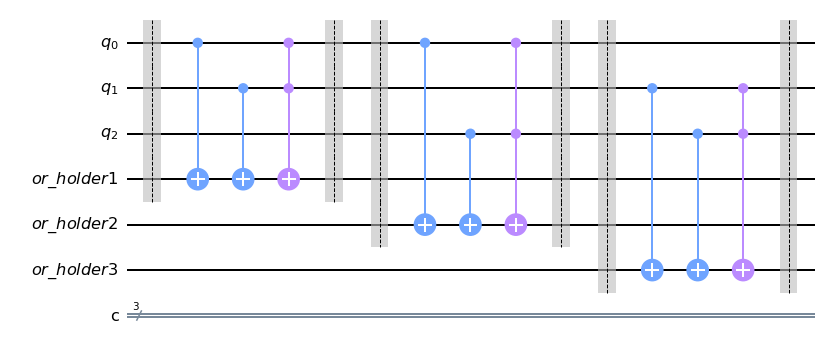

In [5]:
# methods for executing recursive and, or, not, nand gate calls

q_rec = QuantumRegister(3,'q')
c_rec = ClassicalRegister(3,'c')
qc_rec = QuantumCircuit(q_rec,c_rec)


def recursive_and(qc):
    len = qc.num_qubits
    count = 0
    for i in range(len):
        x = i + 1
        for j in range(x, len):
            count = count + 1
            and_qbit(qc, qc.qubits[i], qc.qubits[j], output=QuantumRegister(1, "and_holder" + str(count)))

def recursive_or(qc):
    len = qc.num_qubits
    count = 0
    for i in range(len):
        x = i + 1
        for j in range(x, len):
            count = count + 1
            or_qbit(qc, qc.qubits[i], qc.qubits[j], output=QuantumRegister(1, "or_holder" + str(count)))

def recursive_not(qc):
    len = qc.num_qubits
    for i in range(len):
        not_qbit(qc, qc.qubits[i], output=QuantumRegister(1, "not_holder" + str(i)))

def recursive_nand(qc):
    len = qc.num_qubits
    count = 0
    for i in range(len):
        x = i + 1
        for j in range(x, len):
            count = count + 1
            nand_qbit(qc, qc.qubits[i], qc.qubits[j], output=QuantumRegister(1, "nand_holder" + str(count)))


recursive_or(qc_rec)
display(qc_rec.draw('mpl'))
recursive_and(qc_rec)
#display(qc_rec.draw('mpl'))
recursive_nand(qc_rec)
#display(qc_rec.draw('mpl'))
recursive_not(qc_rec)
#display(qc_rec.draw('mpl'))



# K bit Quantum Adder from two integers

111 10001
00111 10001


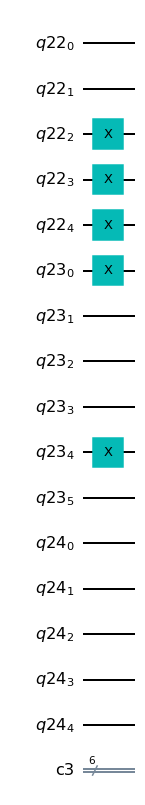

In [24]:
#given two integer values, build a quantum circuit to add them together
def adder(val1, val2):
    
    #------------ circuit initialization ------------
    
    bval = bin(val1)[2:]
    bval2 = bin(val2)[2:]
    print(bval, bval2)
    reg_len = max(len(bval), len(bval2))
    num_1 = QuantumRegister(reg_len) #qubits needed to represent first number
    num_2 = QuantumRegister(reg_len + 1) #qubits needed to represent second number & potential extra qubit for sum
    carry = QuantumRegister(reg_len) #qubits for carry bits
    class_holder = ClassicalRegister(reg_len + 1) #measurements result in sum
    qc = QuantumCircuit(num_1, num_2, carry, class_holder)

    #------------ normalizing binary strings to common length ------------

    diff = abs(len(bval) - len(bval2))
    prep = ''
    for i in range(diff):
        prep = prep + '0'
    if(len(bval) < len(bval2)): #normalize binary strings by prepending 0s
        bval = prep + bval
    elif(len(bval2) < len(bval)):
        bval2 = prep + bval2
    print(bval, bval2)


    #------------ transpose classical numbers to quantum bits ------------
    for j in range(len(bval)):
        if bval[j] == '1':
            qc.x(j)
    # for k in range(len(bval2)):
        if bval2[j] == '1':
            qc.x(len(num_1) + j)

    #----------- adder function ----------
    for j in range(len(bval)):
        if j == 0:
            sum, cOut = adder_func(qc, bval[j], bval2[j])
        else:
            sum, cOut = adder_func(qc, bval[j], bval2[j], cIn=cOut)
    qc.measure(cOut)
    
    display(qc.draw('mpl'))

    


adder(7, 17)